# Customer Segmentation

In [136]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [176]:
df_i_fe = pd.read_pickle('data/df_i_fe.pkl')
df_c_train_fe = pd.read_pickle('data/df_c_train_fe.pkl')
df_t_train_fe = pd.read_pickle('data/df_t_train_fe.pkl')
df_c_val_fe = pd.read_pickle('data/df_c_val_fe.pkl')
df_t_val_fe = pd.read_pickle('data/df_t_val_fe.pkl')
df_c_test_fe = pd.read_pickle('data/df_c_test_fe.pkl')
df_t_test_fe = pd.read_pickle('data/df_t_test_fe.pkl')
df_customers = pd.read_csv('data/customers.csv')


In [177]:
# drop NA values and non-useful columns
cleaned_customers_df = df_customers.dropna(
    subset=["customer_id", "postal_code", "age", "fashion_news_frequency", "club_member_status"]).drop(columns=["FN", "postal_code", "club_member_status", "Active"])

# change "NONE" and "nan" values to "None"
cleaned_customers_df["fashion_news_frequency"] = df_customers["fashion_news_frequency"].replace({"NONE": "None", "None": "None"})

In [178]:
# merge df_c_train_fe with cleaned_customers_df to get age
df_c_train_fe = pd.merge(cleaned_customers_df, df_c_train_fe, on='customer_id', how='inner')
df_c_val_fe = pd.merge(cleaned_customers_df, df_c_val_fe, on='customer_id', how='inner')
df_c_test_fe = pd.merge(cleaned_customers_df, df_c_test_fe, on='customer_id', how='inner')

In [162]:
# # Display the head of each DataFrame
# print("Head of df_i_fe:")
# df_i_fe.head()

# print("Head of df_c_train_fe:")
# df_c_train_fe.head()

# print("Head of df_c_val_fe:")
# df_c_val_fe.head()

# print("Head of df_c_test_fe:")
# df_c_test_fe.head()

# print("Head of df_t_train_fe:")
# df_t_train_fe.head()

# print("Head of df_t_val_fe:")
# df_t_val_fe.head()

# print("Head of df_t_test_fe:")
# df_t_test_fe.head()

In [180]:
norm_unique_values_counts = df_c_train_fe['hours_between_purchases'].value_counts()
print(norm_unique_values_counts)

hours_between_purchases
8760.0    441474
24.0        9201
48.0        8130
72.0        7388
96.0        6758
           ...  
1728.0        20
592.0         20
355.0         16
1776.0        14
1752.0        14
Name: count, Length: 384, dtype: int64


### Differentiating hours_between_purchases via quartiles
1. Exclude "no_repurchase_hours" first
2. Plot Histogram to observe distribution
3. Obtain quantiles
4. Categorise respectively into "Very Short", "Short", "Medium", "Long", "Very Long", "Never"

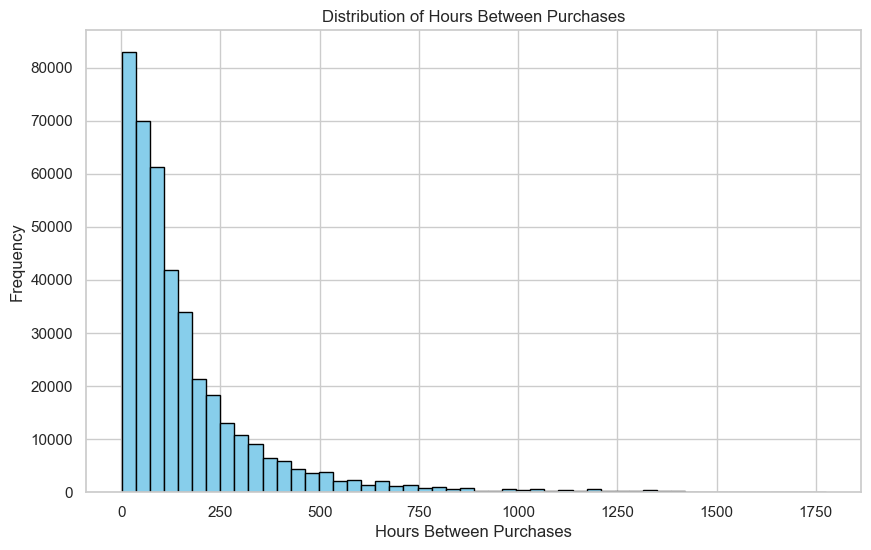

In [181]:
# Exclude "Never"
df_filtered = df_c_train_fe[df_c_train_fe['hours_between_purchases'] != 8760.0]

sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6)) 
plt.hist(df_filtered['hours_between_purchases'], bins=50, color='skyblue', edgecolor='black') 

plt.title('Distribution of Hours Between Purchases')
plt.xlabel('Hours Between Purchases')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [182]:
# Calculate 5 Quantiles (20th, 40th, 60th, 80th percentiles)
quantiles = df_filtered['hours_between_purchases'].quantile([0.2, 0.4, 0.6, 0.8]).to_list()

# Print the calculated boundaries
print(f"Quartile Boundaries: {quantiles}")

Quartile Boundaries: [36.0, 75.0, 130.0, 240.0]


In [183]:
# converts numerical hours to categories
def categorise_hours(hours):
    if hours == 8760.0:
        return "Never"
    elif hours <= quantiles[0]:
        return "Very Short"
    elif hours <= quantiles[1]:
        return "Short"
    elif hours <= quantiles[2]:
        return "Medium"
    elif hours <= quantiles[3]:
        return "Long"
    return "Very Long"

# apply categorization
df_c_train_fe['purchase_behaviour'] = df_c_train_fe['hours_between_purchases'].apply(categorise_hours)

# check the distribution of categories
print(df_c_train_fe['purchase_behaviour'].value_counts())

purchase_behaviour
Never         441474
Very Short     82884
Long           82860
Short          80828
Medium         80426
Very Long      79070
Name: count, dtype: int64


### Preferred Embedding
- uses the features generated via Word2Vec and its associated column "embedding" to merge df_c_** and df_i

## Multi-Feature Clustering
1. Customer Characteristics: age, fashion_news_frequency

`K-Prototypes` - an extension of K-Means that can handle both numerical and categorical data, making it suitable for this mix of data types. It combines the K-Means objective function for numerical data with the K-Modes objective function for categorical data, allowing it to effectively find clusters within mixed data types.

Pro: Specifically designed for clustering mixed data types.

2. Transactional Behaviour:  spending_power, purchase_behaviour

`K-Modes` - clustering categorical data. It uses modes instead of means for clustering, which allows it to handle categories effectively by minimizing the dissimilarities between points in a cluster and maximizing the dissimilarities between different clusters.

Pro: Efficiently clusters categorical data without the need for conversion to numerical formats.

3. Product Preferences: embeddings

`HDBSCAN` - an advanced version of DBSCAN that works well with varying densities, which is common in embedding spaces. 

Pro: Can find clusters of varying shapes and sizes; no need to specify the number of clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 0, ncost: 1689025.6002276419
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 0, ncost: 1689025.6002276419
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 0, ncost: 1689025.6002276419
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 1077, ncost: 341978.43696535064
Run: 1, iteration: 2/10, moves: 158, ncost: 339878.8720601069
Run: 1, iteration: 3/10, moves: 0, ncost: 339878.8720601069
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 3196, ncost: 348597.84331685555
Run: 2, iteration: 2/10, moves: 326, ncost: 339964.8712572874
Run: 2, iteration: 3/10, moves: 32, ncost: 339878.8720601069
Run: 2, iteration: 4/1

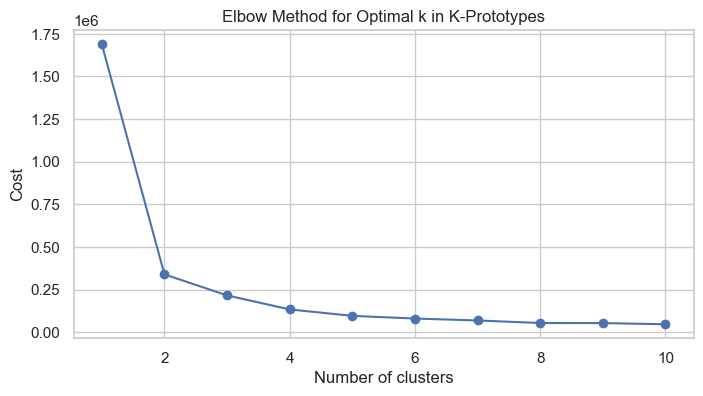

In [197]:
from kmodes.kprototypes import KPrototypes

# find optimal clusters for KProto
data = df_c_train_fe[['age', 'fashion_news_frequency']].copy()
data['fashion_news_frequency'] = data['fashion_news_frequency'].astype(str)

# random sample to improve run time
sampled_data = data.sample(frac=0.01, random_state=42)

costs = []
for k in range(1, 11):
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, max_iter=10, verbose=1)
    kproto.fit(sampled_data, categorical=[1])
    costs.append(kproto.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Prototypes')
plt.show()

In [218]:
# Fit KPrototypes on the full dataset
# From above, optimal number of clusters is 2
kproto_full = KPrototypes(n_clusters=2, n_init=5, max_iter=10, verbose=2)
clusters_kp_full = kproto_full.fit_predict(
    df_c_train_fe[['age', 'fashion_news_frequency']],
    categorical=[1]
)

# Assign the cluster labels to the full dataset
df_c_train_fe['Customer_Characteristics_Cluster'] = clusters_kp_full

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 49573, ncost: 34431496.172160886
Run: 1, iteration: 2/10, moves: 7300, ncost: 34387063.5492253
Run: 1, iteration: 3/10, moves: 0, ncost: 34387063.5492253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 0, ncost: 34387063.5492253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 22159, ncost: 34393293.54505384
Run: 3, iteration: 2/10, moves: 2726, ncost: 34387063.5492253
Run: 3, iteration: 3/10, moves: 0, ncost: 34387063.5492253
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/10, moves: 140266, ncost: 34789896.989391744
Run: 4, iteration: 2/10, moves: 22385, ncost: 34388273.50835033
Run: 4, iteration: 3/10, moves: 1199, ncost:

In [219]:
df_c_train_fe["Customer_Characteristics_Cluster"].value_counts()

Customer_Characteristics_Cluster
0    517625
1    329917
Name: count, dtype: int64

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 0, cost: 7689.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/10, moves: 0, cost: 7689.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/10, moves: 0, cost: 7689.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 317, cost: 5592.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/10, moves: 959, cost: 5592.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/10, moves: 959, cost: 5592.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 1671, cost: 5284.0
Init: initializing centroids
Init: initializing clusters
S

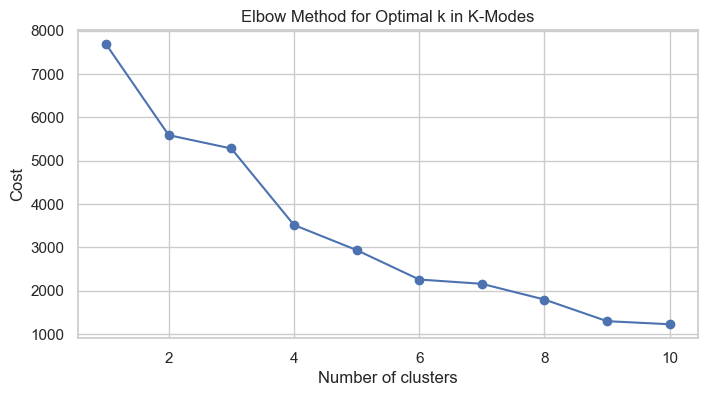

In [214]:
from kmodes.kmodes import KModes

# find optimal clusters for KModes
data_2 = df_c_train_fe[['spending_power', 'purchase_behaviour']].copy()

# random sample to improve run time
sampled_data_2 = data_2.sample(frac=0.01, random_state=42)

costs_2 = []
for k in range(1,11):
    km = KModes(n_clusters=k, init='Huang', n_init=3, max_iter=10, verbose=1)
    km.fit(sampled_data_2)
    costs_2.append(km.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs_2, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Modes')
plt.show()


In [220]:
# From above, the optimal number of clusters is 4
kmodes_full = KModes(n_clusters=4, n_init=5, max_iter=10, verbose=2)

kmodes_full.fit(df_c_train_fe[['spending_power', 'purchase_behaviour']])

# Directly obtain the cluster labels for the full dataset from the fitting process
clusters_km_full = kmodes_full.labels_

# Assign the cluster labels to the full dataset
df_c_train_fe['Transactional_Behaviour_Cluster'] = clusters_km_full

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 29318, cost: 351671.0


In [221]:
df_c_train_fe["Transactional_Behaviour_Cluster"].value_counts()

Transactional_Behaviour_Cluster
0    472866
1    203425
2    133492
3     37759
Name: count, dtype: int64

# Portion below is Teow's EDA

### Number of clusters 

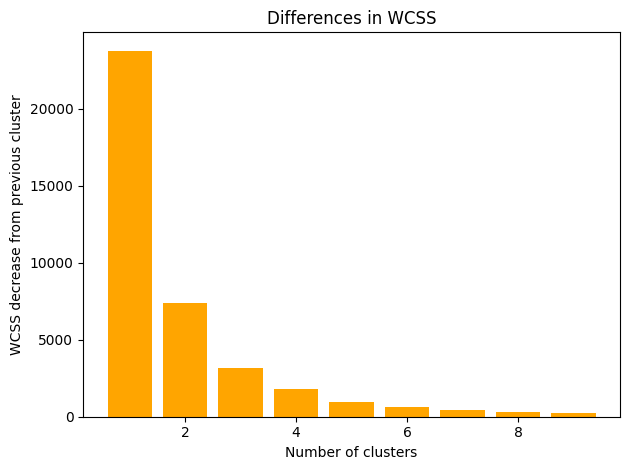

In [47]:
# Compute the differences in consecutive WCSS values to choose number of clusters
wcss_diff = [wcss[i - 1] - wcss[i] for i in range(1, len(wcss))]
plt.bar(range(1, 10), wcss_diff, color='orange')
plt.title('Differences in WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS decrease from previous cluster')


plt.tight_layout()
plt.show()

#### Upon visual inspection of the Elbow Method graph, it is evident that the elbow point is approximately around ***3 clusters***. Additionally, analyzing the difference in consecutive WCSS values provides further insight into the optimal number of clusters. Notably, the most substantial drop in WCSS occurs when transitioning from 2 to 3 clusters, suggesting that the addition of a third cluster significantly improves the clustering quality. 

#### However, beyond three clusters, the decrease in WCSS becomes less pronounced, indicating diminishing returns in terms of clustering improvement. Moreover, increasing the number of clusters excessively may lead to overfitting, where the model captures noise in the data rather than meaningful patterns, potentially reducing the generalization ability of the clustering model. Therefore, based on both visual inspection and the analysis of WCSS differences, selecting three clusters appears to be a reasonable choice for this dataset.

### Categorising Spending Power

In [48]:
quantiles_train = df_c_train_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_val = df_c_val_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_test = df_c_test_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])

def categorize_spending_power(amount, quantiles):
    if amount <= quantiles[0.25]:
        return 'low'
    elif amount <= quantiles[0.75]:
        return 'medium'
    else:
        return 'high'

df_c_train_reduced['spending_power'] = df_c_train_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_train))
df_c_val_reduced['spending_power'] = df_c_val_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_val))
df_c_test_reduced['spending_power'] = df_c_test_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_test))

In [53]:
print(df_c_test_reduced['spending_power'].value_counts())
print(df_c_val_reduced['spending_power'].value_counts())
print(df_c_train_reduced['spending_power'].value_counts())
print(df_c_train_reduced)

spending_power
medium    148271
low        74241
high       74171
Name: count, dtype: int64
spending_power
medium    108324
low        54783
high       54369
Name: count, dtype: int64
spending_power
medium    234880
low       117452
high      117441
Name: count, dtype: int64
                                              customer_id  total_spent  \
0       00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...     0.111814   
1       0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...     0.782712   
2       00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...     0.060983   
3       0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...     0.042339   
4       00009d946eec3ea54add5ba56d5210ea898def4b46c685...     0.772729   
...                                                   ...          ...   
469768  ffff1c80bd2dede87deda612527c3df06d2fb270b85602...     0.064356   
469769  ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...     0.101610   
469770  ffff61677073258d461e043cc9ed4ed97be5617a920640... 

### Insights into product types purchased by different spending power groups

In [73]:
# Tagging products purchased to customers
df_train_merged = pd.merge(df_t_train, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_val_merged = pd.merge(df_t_val, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_test_merged = pd.merge(df_t_test, df_i[['article_id', 'product_type_name']], on='article_id', how='left')

df_train_merged_with_spending_power = pd.merge(df_train_merged, df_c_train_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_val_merged_with_spending_power = pd.merge(df_val_merged, df_c_val_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_test_merged_with_spending_power = pd.merge(df_test_merged, df_c_test_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')

print("Train Data:")
print(df_train_merged_with_spending_power.head())

print("\nValidation Data:")
print(df_val_merged_with_spending_power.head())

print("\nTest Data:")
print(df_test_merged_with_spending_power.head())


Train Data:
       t_dat                                        customer_id  article_id  \
0 2019-04-01  000747860042b94e85707605c2a627c6ba30c4117d025d...   732725002   
1 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   697060014   
2 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   758200004   
3 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   769965001   
4 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   709269004   

      price  sales_channel_id product_type_name spending_power  
0  0.050831                 1             Dress           high  
1  0.025407                 2            Blouse           high  
2  0.067780                 2            Blouse           high  
3  0.042356                 2             Dress           high  
4  0.042356                 2             Dress           high  

Validation Data:
       t_dat                                        customer_id  article_id  \
0 2019-06-15  00015c1a121e

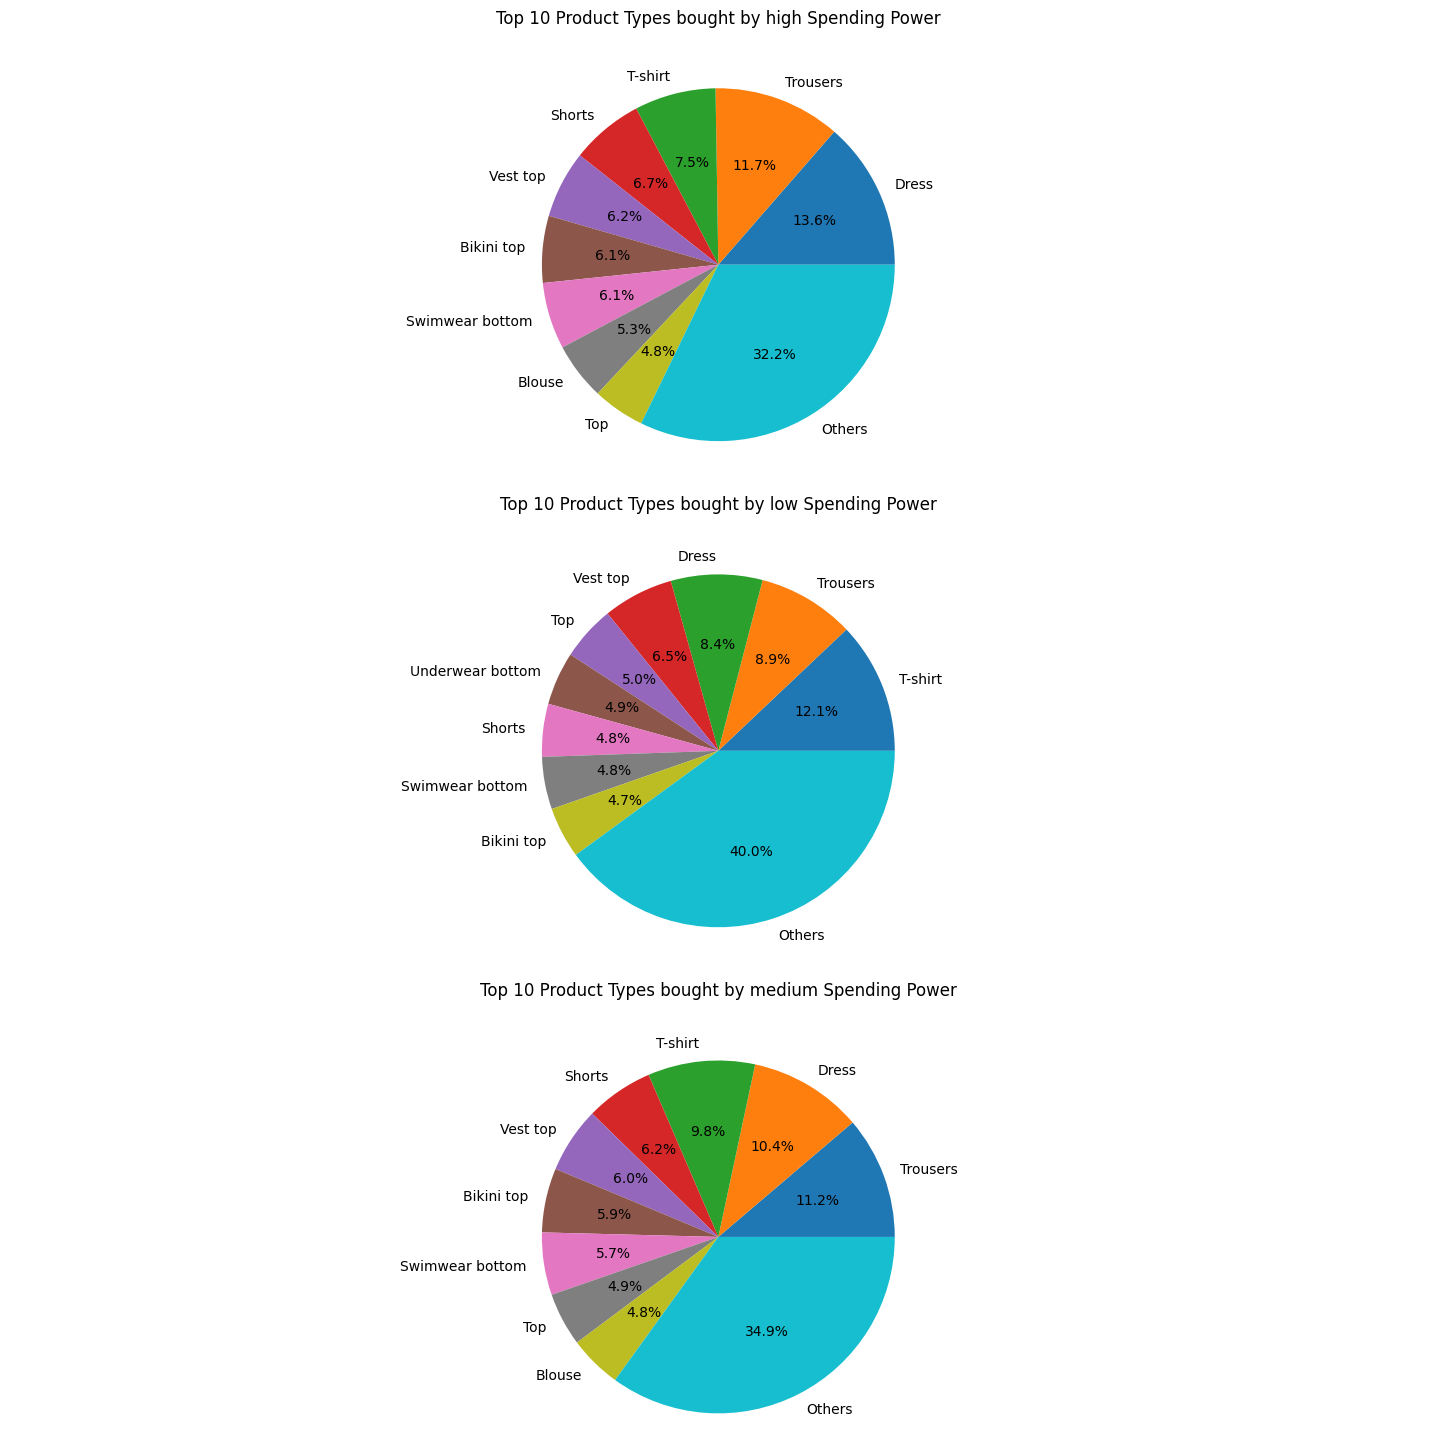

In [72]:
import matplotlib.pyplot as plt

# Group data by spending power and product type and count occurrences
grouped_data = df_train_merged_with_spending_power.groupby(['spending_power', 'product_type_name']).size().reset_index(name='count')
spending_power_categories = grouped_data['spending_power'].unique()

# Plot pie chart for each spending power category
plt.figure(figsize=(15, 5*len(spending_power_categories)))
for i, spending_power in enumerate(spending_power_categories):
    
    # Filter data for the current spending power category
    subset_data = grouped_data[grouped_data['spending_power'] == spending_power]
    
    # Select top 10 product types
    top_10_product_types = subset_data.nlargest(10, 'count')
    
    # Calculate the sum of counts for top 9 product types
    top_9_count = top_10_product_types.iloc[:9]['count'].sum()
    
    # Calculate the count for "Others"
    others_count = subset_data['count'].sum() - top_9_count
    
    # Create a list of labels for the pie chart
    pie_labels = top_10_product_types.iloc[:9]['product_type_name'].tolist()
    pie_labels.append('Others')
    
    # Create a list of counts for the pie chart
    pie_counts = top_10_product_types.iloc[:9]['count'].tolist()
    pie_counts.append(others_count)
    
    # Plot pie chart
    plt.subplot(len(spending_power_categories), 1, i+1)
    plt.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%')
    plt.title(f'Top 10 Product Types bought by {spending_power} Spending Power', y=1.1)
    plt.axis('equal') 

plt.tight_layout(pad=3.0)
plt.show()
